In [0]:
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
import tensorflow as tf
import keras
from keras.layers import Conv2D,Dense,Flatten,Dropout,MaxPool2D
from keras.optimizers import Adam, Adamax, SGD, RMSprop,Nadam
from keras.models import Model, Sequential
from keras.applications.vgg16 import preprocess_input,VGG16
from keras.preprocessing.image import load_img,img_to_array
import pandas as p
import numpy as np
import os
import subprocess
import re
from keras.models import load_model
from scipy import ndimage, misc
from sklearn.model_selection import train_test_split
from keras import regularizers
import skimage
from skimage.io import imread
from skimage import exposure, color
from skimage.transform import resize
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib
from skimage.transform import rescale,resize,downscale_local_mean
import google.colab
from google.colab.patches import cv2_imshow as imshow
from PIL import Image

Using TensorFlow backend.
W0711 09:29:35.528160 140139516336000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0711 09:29:35.545435 140139516336000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0711 09:29:35.552002 140139516336000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0711 09:29:35.576630 140139516336000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session inste

94658560/94653016 [==============================] - 1s 0us/step


In [0]:
base_model =keras.applications.ResNet50(include_top=False, input_tensor=None, input_shape=(150,150,3), pooling=None)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01,l2=0.01))(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01,l2=0.01))(x)
x = Dense(128, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(1, activation='relu')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
weights=np.array(p.read_csv('/content/weights.csv')

In [0]:
firstTime=True
if (firstTime):
  !unzip '-qq' 'people_test.zip'

%cd 'frame'
%pwd
asize=len(np.array(os.listdir('./')))
#memory costraints
asize=2449
print(len(os.listdir('./')))
img_array=np.zeros((asize,150,150,3))
lab_array=np.zeros((asize,1))
res=subprocess.Popen(['ls ./|sort -g'],shell=True, stdout=subprocess.PIPE)
stringlist=res.stdout.read().decode('utf8')
counter=0
for i in stringlist.split(sep='\n'):
  try:
    index=int(re.sub('_.*','',str(os.path.basename(i))))
  except Exception as ex:
    print(ex)
    break  
  lab_array[counter,0]=weights[index,1]
  try:
    img=load_img(i,target_size=(150,150))
  except Exception as ex:
    print(ex)
  imgr=img_to_array(img)
  imgr=imgr.reshape((1,imgr.shape[0],imgr.shape[1],imgr.shape[2]))
  img_array[counter,:]=imgr[0,:]
  counter+=1
  if counter==asize:
    print("Done.")
    break
len(img_array)    

replace frame/0_27_16bit.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
/content/frame
2927


2449

In [0]:
targ_x=np.zeros((img_array.shape[0]*3,img_array.shape[1],img_array.shape[2],img_array.shape[3]))
for i in range(0,len(img_array)-1):
  j=-1*np.ones((img_array.shape[1],img_array.shape[2],img_array.shape[3]))
  j=img_array[i,:,:,:]
  targ_x[i,:,:,:]=j
  j=ndimage.rotate(img_array[i,:,:,:],90,reshape=True)
  targ_x[i+asize,:,:,:]=j
  j=ndimage.rotate(img_array[i,:,:,:],180,reshape=True)
  targ_x[i+asize*2,:,:,:]=j
  
targ_y=np.zeros((lab_array.shape[0]*3,lab_array.shape[1]))

for i in range(0,len(lab_array)-1):
  targ_y[i,0]=lab_array[i,0]
  targ_y[i+asize,0]=lab_array[i,0]
  targ_y[i+asize*2,0]=lab_array[i,0]

img_array=targ_x
lab_array=targ_y

In [0]:
img_array, img_array_test, lab_array, lab_array_test = train_test_split( img_array, lab_array, test_size=0.10, shuffle=True)

In [0]:
from keras.optimizers import SGD,Adam,RMSprop
model.compile(optimizer=Adam(lr=0.001, decay=0.001), loss='mse', metrics=['mae','accuracy','mse'])

W0711 09:30:45.671544 140139516336000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
call=keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error',mode='min',patience=8,restore_best_weights=True)

In [0]:
history = model.fit(img_array,lab_array,epochs=40,initial_epoch=0,batch_size=64,validation_split=0.2,shuffle=True,callbacks=[call])

Train on 5289 samples, validate on 1323 samples
Epoch 1/40
5289/5289 [==============================] - 55s 10ms/step - loss: 943.4501 - mean_absolute_error: 13.2559 - acc: 0.0359 - mean_squared_error: 396.6049 - val_loss: 721.5366 - val_mean_absolute_error: 14.1290 - val_acc: 0.0113 - val_mean_squared_error: 276.1317
Epoch 2/40
5289/5289 [==============================] - 37s 7ms/step - loss: 456.5508 - mean_absolute_error: 6.7857 - acc: 0.0484 - mean_squared_error: 76.2332 - val_loss: 649.5219 - val_mean_absolute_error: 15.9253 - val_acc: 0.0045 - val_mean_squared_error: 323.9578
Epoch 3/40
5289/5289 [==============================] - 37s 7ms/step - loss: 330.4875 - mean_absolute_error: 5.0523 - acc: 0.0631 - mean_squared_error: 42.0502 - val_loss: 330.1348 - val_mean_absolute_error: 6.9771 - val_acc: 0.0385 - val_mean_squared_error: 73.9870
Epoch 4/40
5289/5289 [==============================] - 37s 7ms/step - loss: 264.2119 - mean_absolute_error: 4.3210 - acc: 0.0779 - mean_squared

dict_keys(['val_loss', 'val_mean_absolute_error', 'val_acc', 'val_mean_squared_error', 'loss', 'mean_absolute_error', 'acc', 'mean_squared_error'])


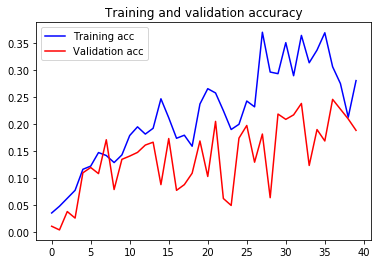

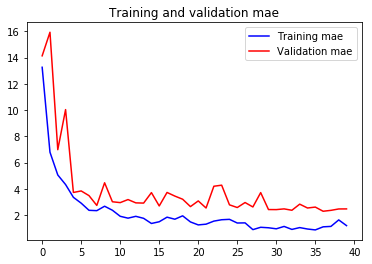

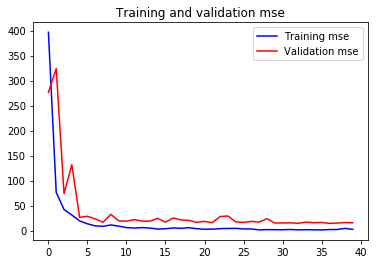

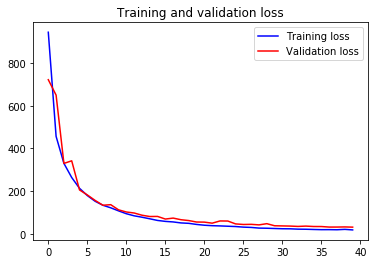

In [0]:
print(history.history.keys())
acc = history.history['acc']
val_acc = history.history['val_acc']
mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, mae, 'b', label='Training mae')
plt.plot(epochs, val_mae, 'r', label='Validation mae')
plt.title('Training and validation mae')
plt.legend()
 
plt.figure()

plt.plot(epochs, mse, 'b', label='Training mse')
plt.plot(epochs, val_mse, 'r', label='Validation mse')
plt.title('Training and validation mse')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

['loss', 'mean_absolute_error', 'acc', 'mean_squared_error']
Testing set Mean Abs Error:  2.50 Kg Testing set accuracy: 0.19592 Testing Mean Square Error: 17.42 kg
[71.53955]


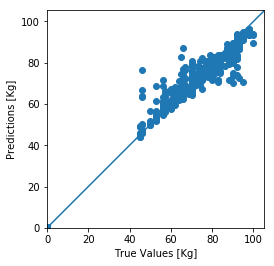

In [0]:
print(model.metrics_names)
loss, mae, acc,mse = model.evaluate(img_array_test, lab_array_test, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} Kg".format(mae),"Testing set accuracy: {:5.5f}".format(acc),"Testing Mean Square Error: {:5.2f} kg".format(mse))

pred=model.predict(img_array_test[0:1])
for j in pred:
  print(j)
predictions =model.predict(img_array_test).flatten()

plt.scatter(lab_array_test, predictions)
plt.xlabel('True Values [Kg]')
plt.ylabel('Predictions [Kg]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 150], [-100, 150])
plt.savefig('/content/pred_res.png')